### Protein Grouping based on AlphaDIA output

Grouping of result proteins is an essential step to prevent inflated protein FDR. The underlying principle of parsimony follows the principle of Occam's razor, where a peptide (herein called precursor) is a single piece of evidence, and we aim to explain all observed precursors with the smallest possible set of proteins. The approach outlined here is based on [Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005) https://www.cs.umd.edu/class/fall2017/cmsc451-0101/Lects/lect09-set-cover.pdf].

As an example for why grouping is necessary, consider Proteins A with peptides (1,2,3,4) and B with peptides (1,2,3). If a proteomics experiment identifies peptides (1,2,3,4), the parsimonious explanation is that only A was present in the sample, since it alone is sufficient to explain the observed peptides. Through a grouping approach, A and B would belong to one group, and the group would be reported as a single ID in the end. If only single proteins are desired, A should be reported and B omitted.

AlphaDIA grouping and parsimony approach:

1. Extract precursor_idx and ids (proteins or genes) column from input psm dataset.
2. Reshape to id-centric view: one row per id, sets of associated precursor indices in the second column. 
3. Perform greedy-set-cover inspired grouping: 
    - Pick the id with the most associated precursors (query) and remove it from the table
    - Iterate over the remaining ids (subjects). For each subject id precursor set, remove all precursors that overlap with the query id precursor set.
        - If the precursor set of a subject id goes to zero, it is considered subsetted by the query id & the two go into one group. Queries that do not subset any other ids are considered singleton groups.
    - Repeat until all remaining ids have a precursor set of zero, or if the last available id has been reached.

This implementation is largely based on a greedy set cover algorithm described in [https://www.cs.umd.edu/class/fall2017/cmsc451-0101/Lects/lect09-set-cover.pdf], and a general description of protein grouping from [Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005)]. Of note, several ambiguous cases can arise for ids which have the exact same number of precursors. In this case, the algorithm will pick the first id in the list, which is arbitrary. Future implementations will employ a weighted set cover approach to resolve these edge cases.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alphadia.grouping import perform_grouping

In [2]:
#example data showcases the collapse of one precursor - multiple protein inputs to one precursor - one master protein (pg_master). All proteins that can be grouped according to 
precursor_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
proteins = ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6']
genes = ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6']
decoy = [0,0,0,0,0,1,1,1,1,1]
df = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": proteins,
    "genes": genes,
    "_decoy": decoy
})

#x = perform_grouping(df, genes_or_proteins = "genes")
x = perform_grouping(df, genes_or_proteins = "genes")
x

,precursor_idx,proteins,genes,_decoy,pg_master,pg
0,0,P1;P2;P3;P4,P1;P2;P3;P4,0,P1,P1;P2;P3
1,0,P1;P2;P3;P4,P1;P2;P3;P4,0,P1,P1;P2;P3
2,1,P1;P2,P1;P2,0,P1,P1;P2;P3
3,1,P1;P2,P1;P2,0,P1,P1;P2;P3
4,2,P4,P4,0,P4,P4
5,2,P4,P4,1,P4,P4
6,3,P4;P5,P4;P5,1,P4,P4;P5
7,3,P4;P5,P4;P5,1,P4,P4;P5
8,4,P6,P6,1,P6,P6
9,4,P6,P6,1,P6,P6


The following edge cases illustrate the protein grouping problem, its algorithmic solutions. Together with circular protein groups, which are a sub-case of subsumable proteins, These cases should cover the expected configurations: 

Adapted from: Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005): 1419-1440. Figure 5:





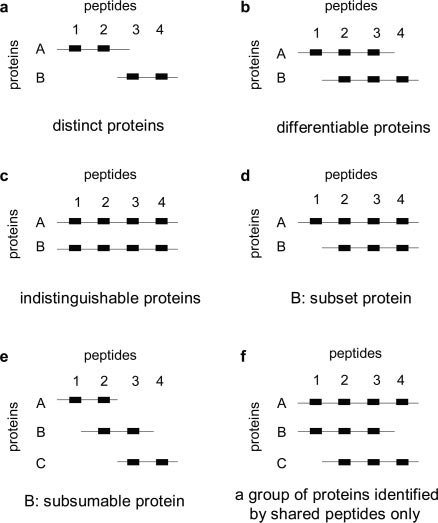

In [3]:
#test cases per Nesvizhskii, Alexey I., and Ruedi Aebersold. "Interpretation of shotgun proteomic data." Molecular & cellular proteomics 4.10 (2005): 1419-1440. Figure 5 (see Appendix)
def test_grouping():

    #1. distinct proteins: both proteins are reported
    distinct_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A", "B", "B"], "_decoy": [0,0,0,0]})
    print("distinct proteins")
    display(distinct_proteins)
    display(perform_grouping(distinct_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(distinct_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A","A","B","B"], "_decoy":[0,0,0,0], "pg_master":["A","A","B","B"], "pg":["A","A","B","B"]}

    #2. differentiable proteins: shared peptides go to one protein
    differentiable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "A;B", "B"], "_decoy": [0,0,0,0]})
    print("differentiable proteins")
    display(differentiable_proteins)
    display(perform_grouping(differentiable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(differentiable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "A;B", "B"], "_decoy":[0,0,0,0], "pg_master":["A","A","A","B"], "pg":["A","A","A","B"]}

    #3. indistinguishable proteins: one is totally removed
    indistinguishable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B", "A;B", "A;B", "A;B"], "_decoy": [0,0,0,0]})
    print("indistinguishable proteins")
    display(indistinguishable_proteins)
    display(perform_grouping(indistinguishable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(indistinguishable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B", "A;B", "A;B", "A;B"], "_decoy":[0,0,0,0], "pg_master":["A","A","A","A"], "pg":["A;B","A;B","A;B","A;B"]}
    
    #4. subset protein: subsetted protein is removed
    subset_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "A;B", "A;B"], "_decoy": [0,0,0,0]})
    print("subset proteins")
    display(subset_proteins)
    display(perform_grouping(subset_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(subset_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "A;B", "A;B"], "_decoy":[0,0,0,0], "pg_master":["A","A","A","A"], "pg":["A;B","A;B","A;B","A;B"]}

    #5. subsumable proteins --> there are two possible outcomes depending on whether one starts with the middle or either end of the chain
    subsumable_proteins = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A", "A;B", "B;C", "C"], "_decoy": [0,0,0,0]})
    print("subsumable proteins")
    display(subsumable_proteins)
    display(perform_grouping(subsumable_proteins, genes_or_proteins = "proteins"))
    assert perform_grouping(subsumable_proteins, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A", "A;B", "B;C", "C"], "_decoy":[0,0,0,0], "pg_master":["A","A","C","C"], "pg":["A","A","C;B","C;B"]}

    #6. a group of proteins identified by shared peptides only
    shared_only = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B", "A;B;C", "A;B;C", "A;C"], "_decoy": [0,0,0,0]})
    print("shared only")
    display(shared_only)
    display(perform_grouping(shared_only, genes_or_proteins = "proteins"))
    assert perform_grouping(shared_only, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B", "A;B;C", "A;B;C", "A;C"], "_decoy":[0,0,0,0], "pg_master":["A","A","A","A"], "pg":["A;B;C","A;B;C","A;B;C","A;B;C"]}

    #7. circular proteins
    circular = pd.DataFrame({"precursor_idx": [1,2,3,4], "proteins": ["A;B;C", "B;C;D", "C;D;E", "D;E;A"], "_decoy": [0,0,0,0]})
    print("circular")
    display(circular)
    display(perform_grouping(circular, genes_or_proteins = "proteins"))
    assert perform_grouping(circular, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[1,2,3,4], "proteins":["A;B;C", "B;C;D", "C;D;E", "D;E;A"], "_decoy":[0,0,0,0], "pg_master":["C","C","C","A"], "pg":["C;B", "C;B", "C;B", "A;D;E"]}

    #8. Complex example --> depending on which of the equivalent proteins P1 and P4 is chosen first, the grouping will be different
    complex_example = pd.DataFrame({"precursor_idx": [0,1,2,3], "proteins": ["P1;P2;P3;P4", "P1;P4", "P2", "P2;P5"], "_decoy": [0,0,0,0]})
    print("complex example")
    display(complex_example)
    display(perform_grouping(complex_example, genes_or_proteins = "proteins"))
    assert perform_grouping(complex_example, genes_or_proteins = "proteins").to_dict(orient = 'list') == {"precursor_idx":[0,1,2,3], "proteins":["P1;P2;P3;P4", "P1;P4", "P2", "P2;P5"], "_decoy":[0,0,0,0], "pg_master":["P2", "P1", "P2", "P2"], "pg":["P2;P3;P5","P1;P4","P2;P3;P5","P2;P3;P5"]}

test_grouping()

distinct proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A,0
2,3,B,0
3,4,B,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A,0,A,A
1,2,A,0,A,A
2,3,B,0,B,B
3,4,B,0,B,B


differentiable proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,A;B,0
3,4,B,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A,0,A,A
1,2,A;B,0,A,A
2,3,A;B,0,A,A
3,4,B,0,B,B


indistinguishable proteins


,precursor_idx,proteins,_decoy
0,1,A;B,0
1,2,A;B,0
2,3,A;B,0
3,4,A;B,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A;B,0,A,A;B
1,2,A;B,0,A,A;B
2,3,A;B,0,A,A;B
3,4,A;B,0,A,A;B


subset proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,A;B,0
3,4,A;B,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A,0,A,A;B
1,2,A;B,0,A,A;B
2,3,A;B,0,A,A;B
3,4,A;B,0,A,A;B


subsumable proteins


,precursor_idx,proteins,_decoy
0,1,A,0
1,2,A;B,0
2,3,B;C,0
3,4,C,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A,0,A,A
1,2,A;B,0,A,A
2,3,B;C,0,C,C;B
3,4,C,0,C,C;B


shared only


,precursor_idx,proteins,_decoy
0,1,A;B,0
1,2,A;B;C,0
2,3,A;B;C,0
3,4,A;C,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A;B,0,A,A;B;C
1,2,A;B;C,0,A,A;B;C
2,3,A;B;C,0,A,A;B;C
3,4,A;C,0,A,A;B;C


circular


,precursor_idx,proteins,_decoy
0,1,A;B;C,0
1,2,B;C;D,0
2,3,C;D;E,0
3,4,D;E;A,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,1,A;B;C,0,C,C;B
1,2,B;C;D,0,C,C;B
2,3,C;D;E,0,C,C;B
3,4,D;E;A,0,A,A;D;E


complex example


,precursor_idx,proteins,_decoy
0,0,P1;P2;P3;P4,0
1,1,P1;P4,0
2,2,P2,0
3,3,P2;P5,0


,precursor_idx,proteins,_decoy,pg_master,pg
0,0,P1;P2;P3;P4,0,P2,P2;P3;P5
1,1,P1;P4,0,P1,P1;P4
2,2,P2,0,P2,P2;P3;P5
3,3,P2;P5,0,P2,P2;P3;P5
